# Load data with PyTorch Datasets and DataLoaders

In [1]:
%matplotlib inline

## Datasets and Dataloaders
데이터 샘플을 처리하기 위한 코드는 지저분하고 유지관리하기 어려울 수 있습니다. 더 나은 가독성과 모듈성을 위해 데이터셋 코드와 모델의 학습코드는 분리하는 것이 이상적입니다. PyTorch는 두 가지 데이터 기본 기능을 활용하여 사전 정의 데이터셋(`torch.utils.data.Dataset`)과 자체 데이터(`torch.utils.data.DataLoader`)를 사용할 수 있습니다.`Dataset`은 데이터와 레이블을 저장하고 `DataLoader`는 샘플에 쉽게 접근할 수 있도록 `Dataset` 주위에 iterable을 래핑합니다.

PyTorch 도메인 라이브러리는 FashionMNIST과 같은 미리 정의된 다양한 데이터셋을 제공합니다. 하위 클래스 `torch.utils.data.DataLoader` 의 특정 함수 및 데이터로 불어올 수 있습기 때문에 모델의 벤치마킹 및 프로토타입 제작에 활용할 수 있습니다. 

다음의 링크에서 찾을 수 있습니다:
[Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

### Loading a dataset
아래는 TorchVision으로 부터 [Fashion-MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) 을 읽는 예제입니다. Fashion-MNIST는 60,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성된 Zalando의 아티클 이미지입니다. 각 샘플은 28×28의 그레이스케일 이미지이며 10개의 범주 중 하나와 연관되어 있습니다.

우리는 아래의 파라미터를 사용하여 [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)를 호출합니다.|
- **root**은 데이터를 저정하는 위치입니다.
- **train**은 train 혹은 test 데이터셋을 특정합니다.
- **download=True**는 `root`에 데이터가 없는 경우 인터넷으로 데이터를 다운받습니다.
- **transform**과 **target_transform**은 피처와 레이블 변환을 명시합니다.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data", # data path
    train=True,
    download=True, # root에 데이터가 없는 경우 다운받음
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Iterating and Visualizing the Dataset
---
`training_data[index]` 데이터셋에 순서를 의미하는 숫자를 부여하고, 
훈련 데이터 중 일부를 시각화하기 위해 `matplotlib`를 사용합니다.

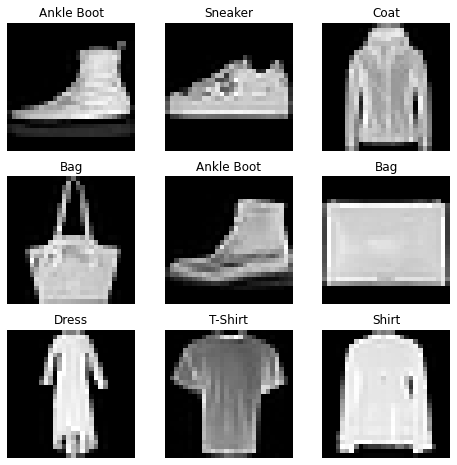

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Creating a Custom Dataset for your files
---
사용자 정의 데이터셋 클래스는 3가지 함수를 꼭 구현해야 합니다:`__init__`, `__len__`, `__getitem__`. 이들 구현을 살펴보면, FashineMNIST 이미지는 `img_dir`에 저장되어 있으며 레이블은 `annotations_file`에 csv 파일로 구분되어 저장되어 있습니다. 
    
다음 섹션에서는 이들 함수에서 무엇이 일어나는지 상세하게 살펴보겠습니다.

In [4]:
import os 
import pandas as pd 
import torchvision.io as tvio

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = tvio.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.transform
        sample = {"image":image, "label":label}
        return sample    

### init
`__init__` 함수는 데이터셋 오브젝트 초기화 시 한번 동작합니다. 이미지와 주석, 모두의 변환을 포함한 디렉토리를 초기화합니다(다음 세션에 자세히 설명).

The labels.csv file looks like:
```
    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9
```
Example:
```
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

### len
`__len__` 함수는 데이터셋의 샘플 수를 반환합니다.

Example:
```
def __len__(self):
    return len(self.img_labels)
```

### getitem
`__getitem__` 함수는 주어진 인덱스의 데이터셋 샘플을 읽어서 반환합니다. index를 기준으로 디스크에서 이미지 위치를 식별하고, `read_image` 함수를 사용하여 텐서로 변환하고 검색합니다. 또한, `self.img_labels`의 csv data로부터 레이블을 인식하여 반환하고, 변환함수를 호출하여 최종으로는 텐서 이미지와 레이블을 python의 `dict`으로 반환합니다.

```
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample
```

## Preparing your data for training with DataLoaders

`Dataset`은 한 번에 하나의 이미지와 레이블을 반환합니다. 모델을 학습하는 동안에는 minibatch 단위로 샘플이 통과되고, overfitting 현상을 줄이기 위해 매 epoch마다 데이터 위치가 변경되며, 멀티 프로세싱을 통해 데이터 반환 |속도를 높이길 희망합니다. 

`DataLoader`는 이러한 복잡한 요구를 손쉬운 API로 추상화한 이터러블 오브젝트입니다. 

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

해당 데이터셋을 `DataLoader`에 담아서, 필요에 따라 데이터셋을 반복하여 로드하고 있습니다. 아래의 각 반복은 `train_feature`와 `train_label`의 묶음을 반환합니다(`batch_size=64`)하며, 모든 묶음에 걸쳐서 반복이 완료되면 데이터 위치는 섞입니다(데이터 순서를 더 미세하게 조절하고 싶다면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>)를 참고하세요). 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


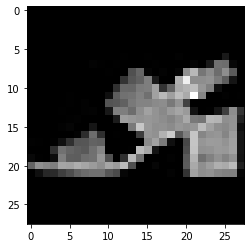

Label: 5


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")